In [2]:
import mglearn
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures

In [3]:
citibike = mglearn.datasets.load_citibike()

# Series with DateTime index
citibike.head()

starttime
2015-08-01 00:00:00     3
2015-08-01 03:00:00     0
2015-08-01 06:00:00     9
2015-08-01 09:00:00    41
2015-08-01 12:00:00    39
Freq: 3H, Name: one, dtype: int64

Text(0, 0.5, 'Rentals count')

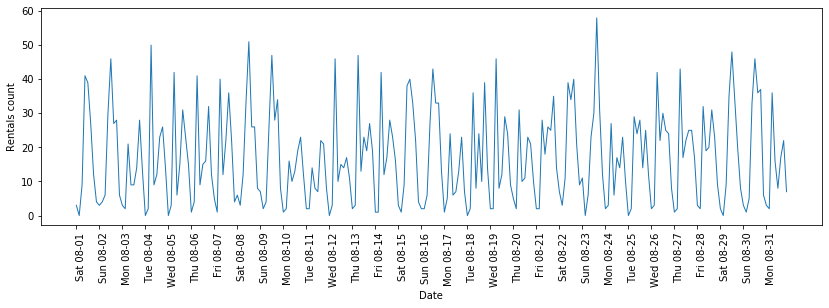

In [5]:
plt.figure(figsize=(14, 4))
xticks = pd.date_range(start=citibike.index.min(), end=citibike.index.max(), # datetime index
                      freq='D') # calendar day frequency
plt.xticks(xticks, xticks.strftime('%a %m-%d'), rotation=90, ha='left')
plt.plot(citibike, linewidth=1)
plt.xlabel('Date')
plt.ylabel('Rentals count')

In [6]:
# Target
y = citibike.values

# Convert the time to POSIX time using '%s'
X = np.asarray(citibike.index.strftime('%s').astype('int')).reshape(-1, 1)

In [7]:
# Time-series: first 184 data points for training
n_train = 184

# Evaluate and plot a regressor on a given feature set
def eval_on_features(features, target, regressor):
    X_train, X_test = features[:n_train], features[n_train:]
    y_train, y_test = target[:n_train], target[n_train:]
    regressor.fit(X_train, y_train)
    print('Test score R2: {:.3f}'.format(regressor.score(X_test, y_test)))
    y_pred = regressor.predict(X_test)
    y_pred_train = regressor.predict(X_train)
    plt.figure(figsize=(14, 4))
    plt.xticks(range(0, len(X), 8), xticks.strftime('%a %m-%d'), rotation=90, ha='left')
    plt.plot(range(n_train), y_train, label='train')
    plt.plot(range(n_train, n_train + len(y_test)), y_test, '-', label='test')
    plt.plot(range(n_train, n_train + len(y_test)), y_pred, '--', label='prediction test')
    plt.plot(range(n_train), y_pred_train, '--', label='prediction train')
    plt.legend(loc='best')
    plt.xlabel('Date')
    plt.ylabel('Rentals count')

Test score R2: -0.035


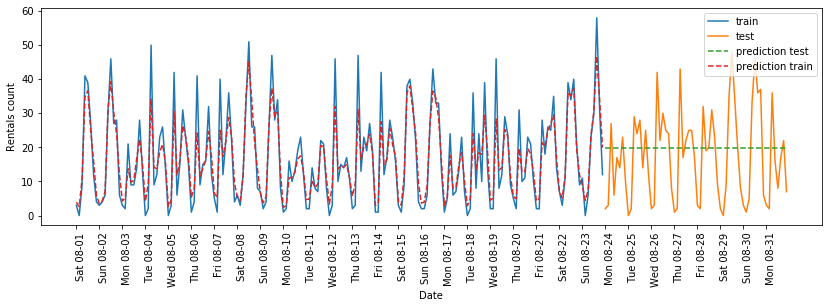

In [8]:
regressor = RandomForestRegressor(n_estimators=100, random_state=0)
eval_on_features(X, y, regressor)

# Random forest can't extrapolate out of the range of training set

Test score R2: 0.600


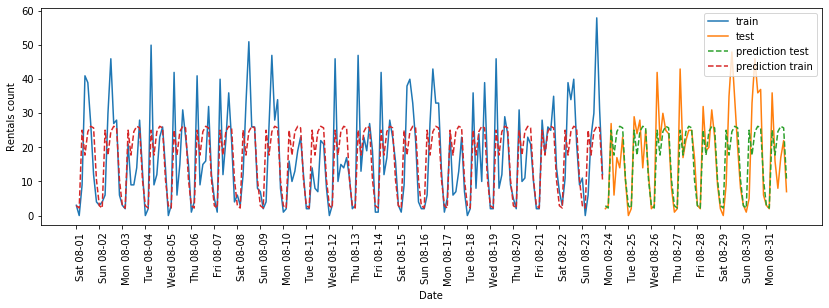

In [9]:
# Add hour of day as feature

X_hour = np.asarray(citibike.index.hour.to_list()).reshape(-1, 1)
eval_on_features(X_hour, y, regressor)

Test score R2: 0.842


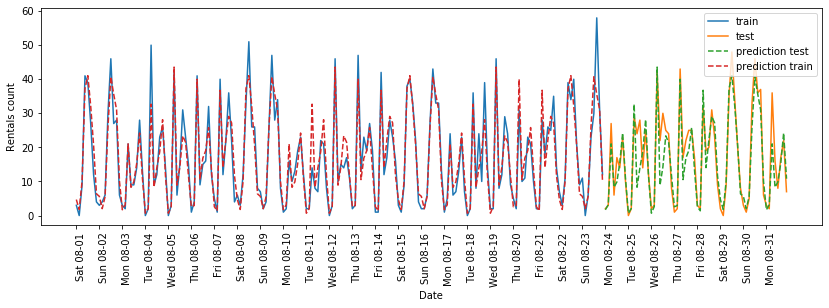

In [10]:
# Add day of week as feature

X_day_week = np.asarray(citibike.index.dayofweek.to_list()).reshape(-1, 1)
X_hour_week = np.hstack([X_hour, X_day_week])
eval_on_features(X_hour_week, y, regressor)

Test score R2: 0.132


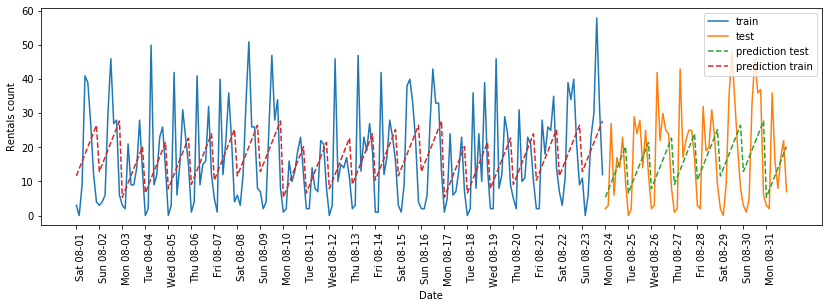

In [11]:
# Try simpler model

eval_on_features(X_hour_week, y, LinearRegression())

In [12]:
# Current features: 1-st row - hour of day, 2nd row - day of week
display(pd.DataFrame(X_hour_week, columns=['hour of day', 'day of week']).head(10).transpose())
print(X_hour_week.dtype)

,0,1,2,3,4,5,6,7,8,9
hour of day,0,3,6,9,12,15,18,21,0,3
day of week,5,5,5,5,5,5,5,5,6,6


int64


In [13]:
# Transform day of week and hour of day with one hot encoding

encoder = OneHotEncoder(categories='auto')
X_hour_week_onehot = encoder.fit_transform(X_hour_week).toarray()
display(pd.DataFrame(X_hour_week_onehot).head())

# 15 features = 7 separate features for day + 8 separate features for time

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


Test score R2: 0.619


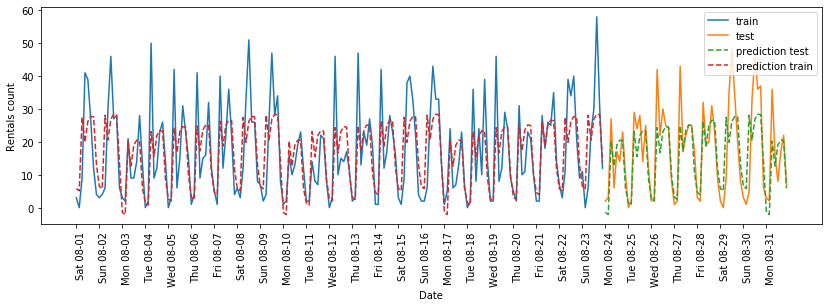

In [14]:
# Onehot encoded day of week and hour of day
eval_on_features(X_hour_week_onehot, y, Ridge())

In [15]:
X_train, X_test = X_hour_week_onehot[:n_train], X_hour_week_onehot[n_train:]
y_train, y_test = y[:n_train], y[n_train:]
ridge = Ridge()
ridge.fit(X_train, y_train)
print('Test score R2: {:.3f}'.format(ridge.score(X_test, y_test)))
print('Number of coefs: {}'.format(len(ridge.coef_)))
print('Coefs: ', ridge.coef_)

# 15 coefficients - for each day of week and for each hour of day(3)
# SO, coefficients for hours of day are the same for each day

Test score R2: 0.619
Number of coefs: 15
Coefs:  [-13.328125   -13.99479167   8.33854167   0.75520833   7.13020833
   8.63020833   8.50520833  -6.03645833  -4.66820144  -1.78820144
  -0.58820144  -0.06820144   1.37179856   2.53717026   3.20383693]


Test score R2: 0.845


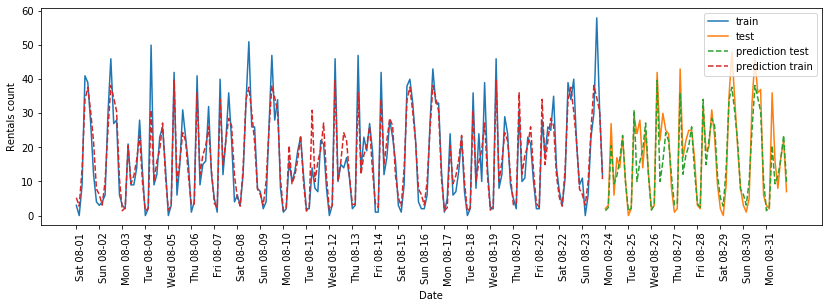

In [16]:
# Make possible different coefficients for hour of day in different days 

poly_transformer = PolynomialFeatures(degree=2,
                                      interaction_only=True,
                                      include_bias=False)

X_hour_week_onehot_poly = poly_transformer.fit_transform(X_hour_week_onehot)
lr = Ridge()
eval_on_features(X_hour_week_onehot_poly, y, lr)

In [17]:
X_train, X_test = X_hour_week_onehot_poly[:n_train], X_hour_week_onehot_poly[n_train:]
y_train, y_test = y[:n_train], y[n_train:]
ridge = Ridge()
ridge.fit(X_train, y_train)
print('Test score R2: {:.3f}'.format(ridge.score(X_test, y_test)))
print('Number of coefs: {}'.format(len(ridge.coef_)))

# Sufficient number of coefs for each combination of hour of day and day of week
# One coef for each time and day

Test score R2: 0.845
Number of coefs: 120


Text(0, 0.5, 'Feature magnitude')

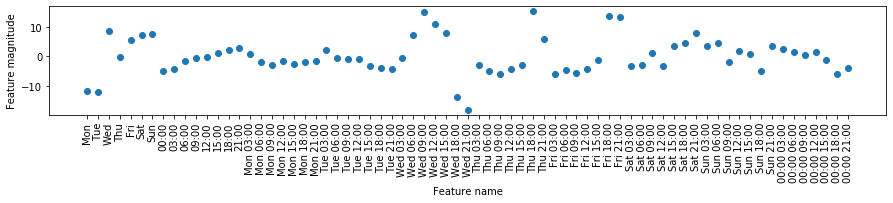

In [18]:
# Plot coefs

hour = ["%02d:00" % i for i in range(0, 24, 3)]
day = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]
features = day + hour

features_poly = poly_transformer.get_feature_names(features) # provide names for features
features_nonzero = np.array(features_poly)[lr.coef_ != 0] # only features with non-zero coefs
coef_nonzero = lr.coef_[lr.coef_ != 0]

plt.figure(figsize=(15, 2))
plt.plot(coef_nonzero, 'o')
plt.xticks(np.arange(len(coef_nonzero)), features_nonzero, rotation=90)
plt.xlabel('Feature name')
plt.ylabel('Feature magnitude')